In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation

from sklearn.preprocessing import LabelEncoder

#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf
import seaborn as sns

import sklearn
from pathlib import Path
from warnings import simplefilter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#LSTM Encoder

In [3]:
# Set up GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [4]:
def generate_input_output_pairs(data, time_steps, target_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps - target_steps + 1):
        X.append(data[i:i+time_steps,:])
        y.append(data[i+time_steps:i+time_steps+target_steps,:])
    return np.array(X), np.array(y)

In [5]:
data = pd.read_csv('/content/drive/MyDrive/data/dataTS.csv', 
                   usecols = ['Time', 'pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp',
       'TEMP'], index_col= 'Time', parse_dates=['Time']).reindex(columns=['pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp',
       'TEMP'])
# data["Date_time"] = data.index.strftime('%H:%M:%S')
# data["Month"] = data.index.month
# data["Day"] = data.index.day
# for colname in data.select_dtypes(["object", "category"]):
#     data[colname], _ = data[colname].factorize()
data_train, data_test = train_test_split(
    data, test_size= 100, shuffle=False)
data_train, data_val = train_test_split(
    data_train, test_size= 100, shuffle=False)

In [6]:
X_train, y_train = generate_input_output_pairs(data_train.values, time_steps=20, target_steps=10)
X_val, y_val = generate_input_output_pairs(data_val.values, time_steps=20, target_steps=10)
X_test, y_test = generate_input_output_pairs(data_test.values, time_steps=20, target_steps=10)

In [7]:
num_features = 9
time_steps = 20
target_steps = 10

In [ ]:
# Define autoencoder model
input_layer = tf.keras.layers.Input(shape=(time_steps, num_features))
encoder = tf.keras.layers.LSTM(16, activation='relu')(input_layer)
# encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.RepeatVector(target_steps)(encoder)
# decoder = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(encoder)
decoder = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoder)
output_layer = tf.keras.layers.TimeDistributed(Dense(num_features))(decoder)
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 16)                1664      
                                                                 
 repeat_vector (RepeatVector  (None, 10, 16)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            6272      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 64)            24832     
                                                             

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_train], [y_train],
                    validation_data=([X_val], [y_val]), 
                          batch_size=256, 
                          epochs=50, 
                          verbose=1, callbacks=[callback])

Epoch 1/50
1325/1325 [==============================] - 125s 89ms/step - loss: 39632.9922 - val_loss: 3847.6189
Epoch 2/50
1325/1325 [==============================] - 107s 81ms/step - loss: 4834.2339 - val_loss: 2553.6707
Epoch 3/50
1325/1325 [==============================] - 104s 79ms/step - loss: 4356.6152 - val_loss: 2474.1357
Epoch 4/50
1325/1325 [==============================] - 106s 80ms/step - loss: 4378.9961 - val_loss: 2254.6387
Epoch 5/50
1325/1325 [==============================] - 105s 79ms/step - loss: 3844.8552 - val_loss: 2240.7056
Epoch 6/50
1325/1325 [==============================] - 105s 79ms/step - loss: 3057.2764 - val_loss: 2127.6658
Epoch 7/50
1325/1325 [==============================] - 104s 79ms/step - loss: 2947.0540 - val_loss: 2227.7747
Epoch 8/50
1325/1325 [==============================] - 104s 79ms/step - loss: 2891.7651 - val_loss: 2025.2170
Epoch 9/50
1325/1325 [==============================] - 105s 79ms/step - loss: 2641.5110 - val_loss: 2387.7830


In [ ]:
y_pred = model.predict(X_test)
np.save('lstm_autoencoder.npy', y_pred)

3/3 [==============================] - 0s 11ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error
for i,j in zip(range(9),['pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp', 'TEMP']):
  print(j,' RMSE ',mean_squared_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i], squared = False))
  print(j,' MAE ',mean_absolute_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i]))

pH  RMSE  5.103794697641115
pH  MAE  5.089440873025168
DO  RMSE  1.962196594553955
DO  MAE  1.9413930518996545
TSS  RMSE  108.14016467080768
TSS  MAE  89.15515032498638
TN  RMSE  1.8155132136394359
TN  MAE  1.4799022241175388
TP  RMSE  59.021889717741445
TP  MAE  43.08325225074291
TOC  RMSE  9.42306058702403
TOC  MAE  7.598937524720892
ORP  RMSE  81.53803852772512
ORP  MAE  81.00428059150802
Temp  RMSE  1.172689327168443
Temp  MAE  0.9645944366455077
TEMP  RMSE  5.2348903844237045
TEMP  MAE  4.179064401574714


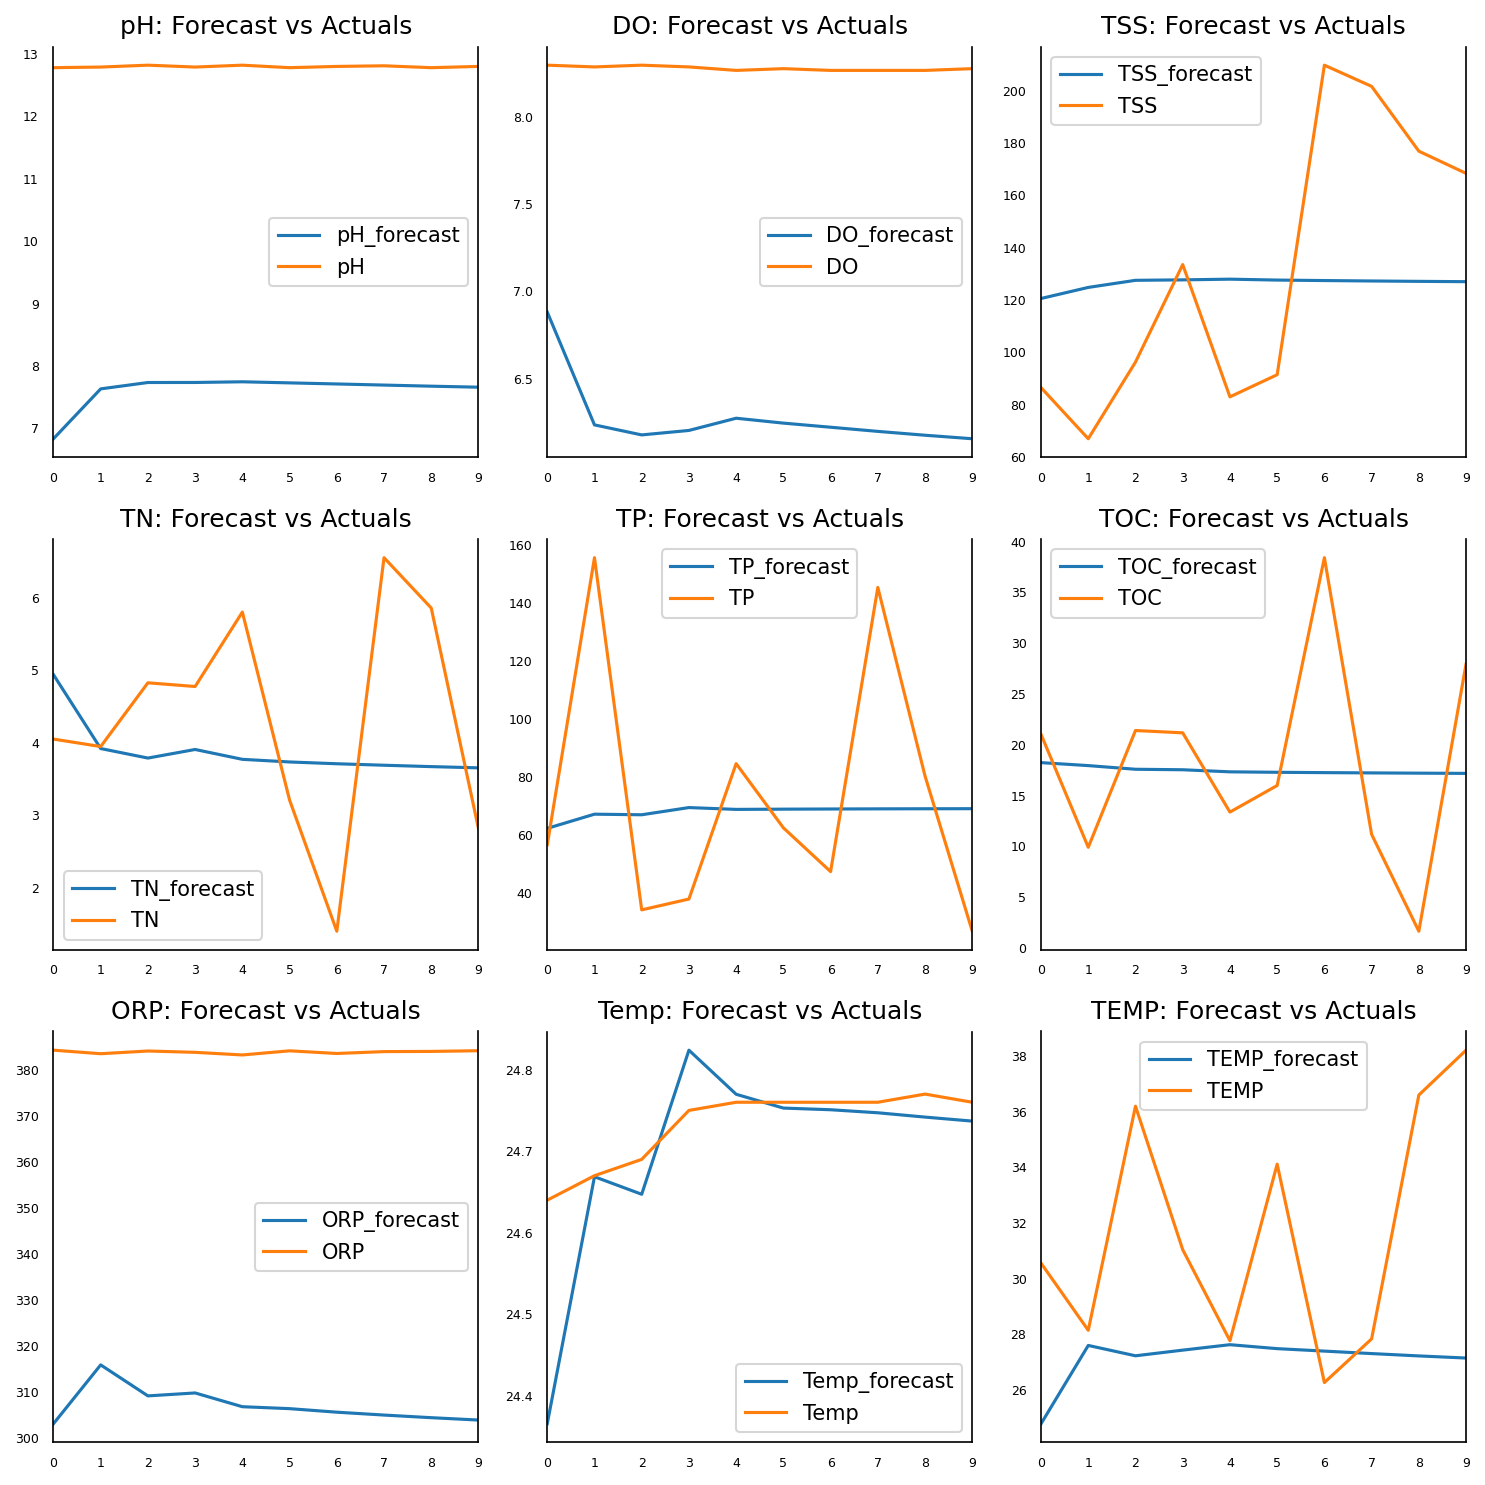

In [ ]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results = pd.DataFrame({f'{col}_forecast': y_pred[-1][:,i]})
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test = pd.DataFrame({f'{col}': y_test[-1][:,i]})
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout(); 

#Conv

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from tensorflow.keras.layers import concatenate

In [27]:
# Xây dựng mô hình convolution dilated
def build_dilated_cnn_model(n_timesteps, n_features, dilation_rates=[1,2,4,8], n_filters=32, kernel_size=3, dropout_rate=0.2):
    # Đầu vào mô hình
    inputs = Input(shape=(n_timesteps, n_features))

    # Áp dụng các lớp Conv1D với dilation_rates khác nhau
    x = inputs
    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, activation='relu', padding='causal')(x)
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    
    # Đầu ra mô hình
    x = Conv1D(filters=9, kernel_size=11, activation='linear')(x)
    outputs = Conv1D(filters=9, kernel_size=1, activation='linear')(x)

    # Đóng gói mô hình
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Chuẩn bị dữ liệu và huấn luyện mô hình
# ... (code bổ sung ở đây)

# Xây dựng mô hình
model = build_dilated_cnn_model(n_timesteps=20, n_features=9)

# Biên dịch mô hình và huấn luyện với dữ liệu
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 9)]           0         
                                                                 
 conv1d_19 (Conv1D)          (None, 20, 32)            896       
                                                                 
 dropout_12 (Dropout)        (None, 20, 32)            0         
                                                                 
 conv1d_20 (Conv1D)          (None, 20, 32)            3104      
                                                                 
 dropout_13 (Dropout)        (None, 20, 32)            0         
                                                                 
 conv1d_21 (Conv1D)          (None, 20, 32)            3104      
                                                                 
 dropout_14 (Dropout)        (None, 20, 32)            0   

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=50, verbose =1, batch_size=64, validation_data=(X_val, y_val),
          callbacks=[callback])

Epoch 1/50
5300/5300 [==============================] - 37s 7ms/step - loss: 2439.1487 - val_loss: 3412.9536
Epoch 2/50
5300/5300 [==============================] - 36s 7ms/step - loss: 2135.6316 - val_loss: 4520.6016
Epoch 3/50
5300/5300 [==============================] - 35s 7ms/step - loss: 2087.0928 - val_loss: 4155.4766
Epoch 4/50
5300/5300 [==============================] - 35s 7ms/step - loss: 2054.5547 - val_loss: 3958.2402
Epoch 5/50
5300/5300 [==============================] - 35s 7ms/step - loss: 2040.8759 - val_loss: 3610.2524
Epoch 6/50
5300/5300 [==============================] - 34s 6ms/step - loss: 2024.2930 - val_loss: 3145.4978
Epoch 7/50
5300/5300 [==============================] - 35s 7ms/step - loss: 2017.9358 - val_loss: 3089.3203
Epoch 8/50
5300/5300 [==============================] - 36s 7ms/step - loss: 2009.6864 - val_loss: 3405.4124
Epoch 9/50
5300/5300 [==============================] - 35s 7ms/step - loss: 2001.9456 - val_loss: 3387.5608
Epoch 10/50
5300/53

In [29]:
y_pred = model.predict(X_test)
np.save('conv.npy', y_pred)

3/3 [==============================] - 0s 5ms/step


In [30]:
for i,j in zip(range(9),['pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp', 'TEMP']):
  print(j,' RMSE ',mean_squared_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i], squared = False))
  print(j,' MAE ',mean_absolute_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i]))

pH  RMSE  5.054233060031979
pH  MAE  5.051147979467688
DO  RMSE  1.642513400597871
DO  MAE  1.6402167167932213
TSS  RMSE  108.80831726048878
TSS  MAE  89.47487719118573
TN  RMSE  1.7528295216490848
TN  MAE  1.447486735392839
TP  RMSE  58.980740924067184
TP  MAE  45.16782766805216
TOC  RMSE  9.384040724442977
TOC  MAE  7.5087018907266145
ORP  RMSE  110.14132772312836
ORP  MAE  110.06598146078619
Temp  RMSE  1.7611867684657305
Temp  MAE  1.612740490013445
TEMP  RMSE  4.0459498369418725
TEMP  MAE  3.397949407039053


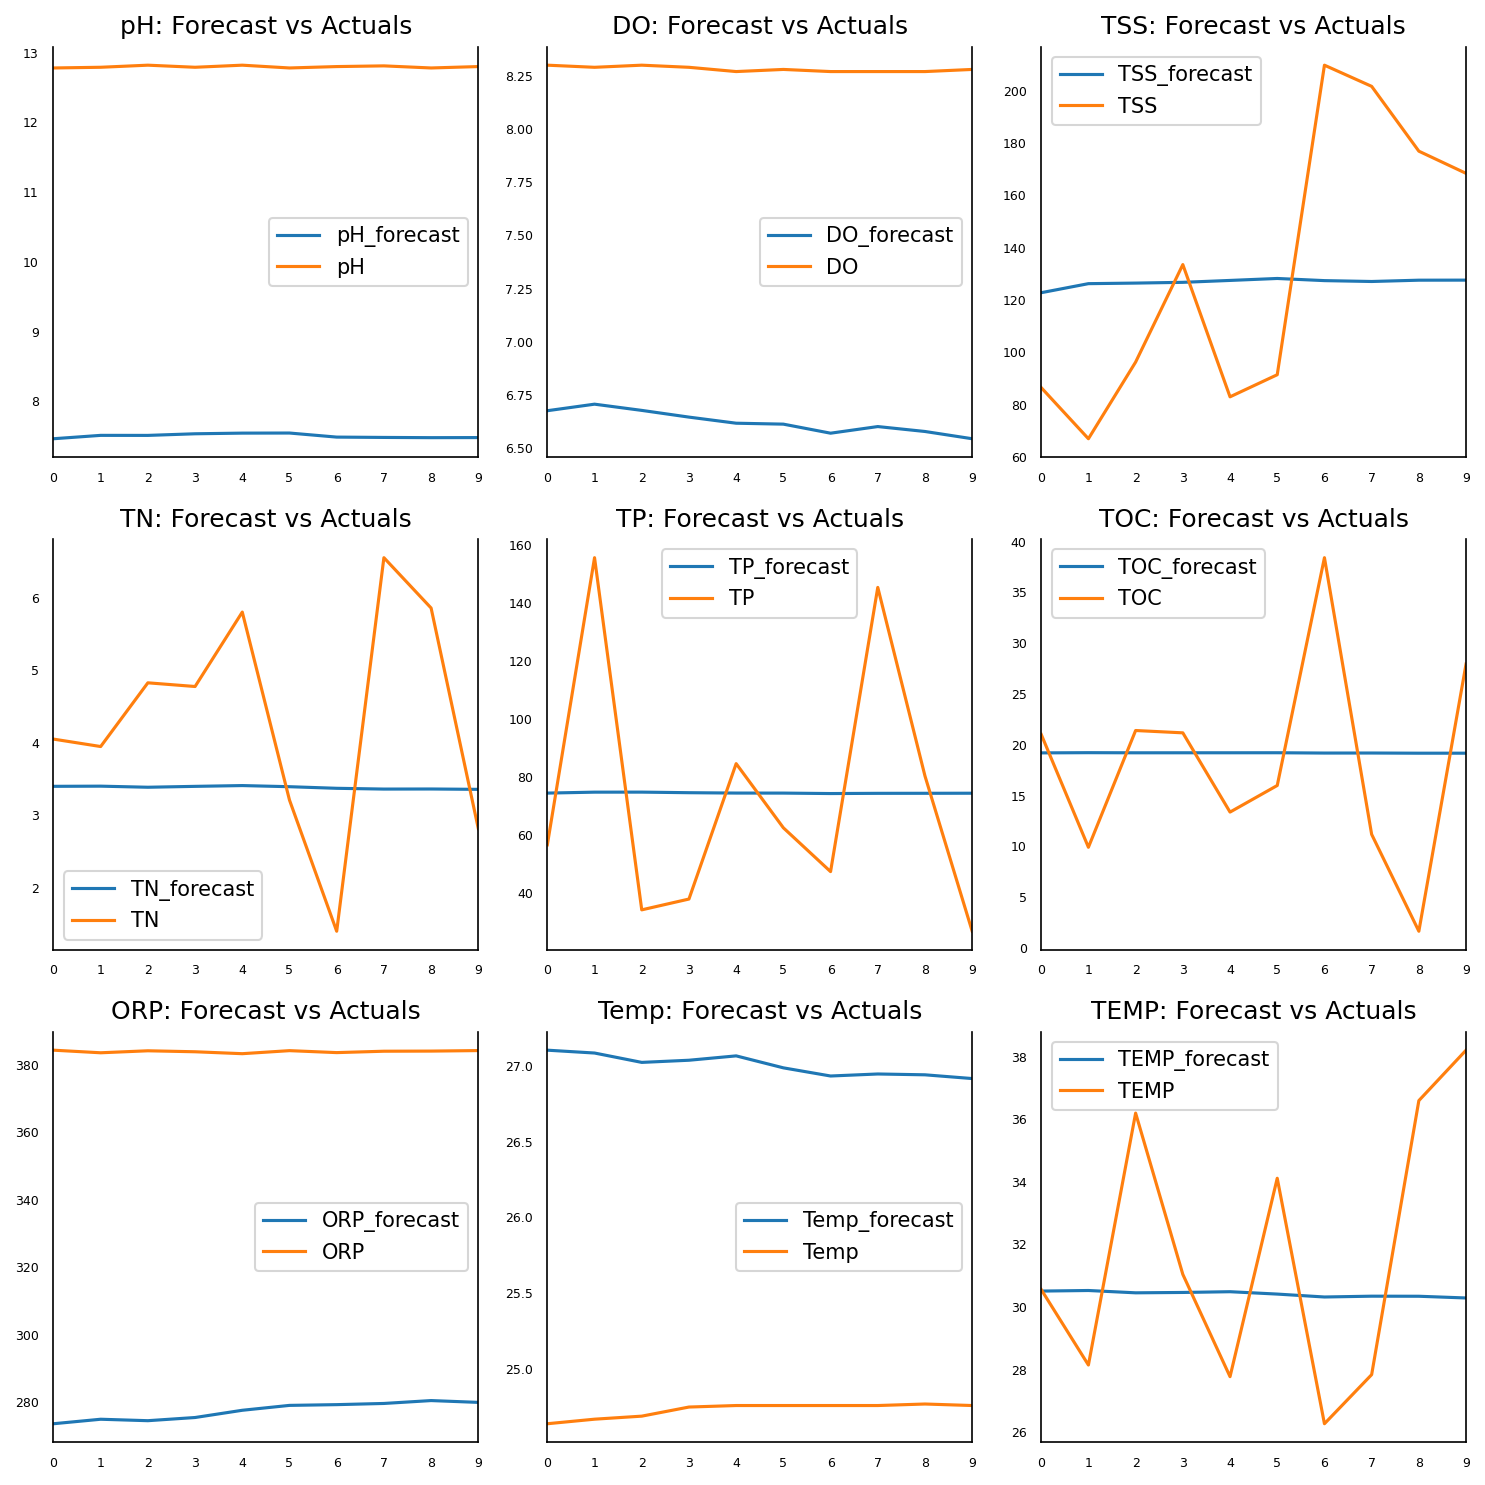

In [31]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results = pd.DataFrame({f'{col}_forecast': y_pred[-1][:,i]})
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test = pd.DataFrame({f'{col}': y_test[-1][:,i]})
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout(); 

#Conv1D + skip_connection

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Xây dựng mô hình convolution dilated với skip connection
def build_dilated_cnn_model(n_timesteps, n_features, dilation_rates=[1,2,4], n_filters=16, kernel_size=3, dropout_rate=0.2):
    # Đầu vào mô hình
    inputs = Input(shape=(n_timesteps, n_features))

    # Áp dụng các lớp Conv1D với dilation_rates khác nhau và skip connection
    skip_connections = []
    
    x = tf.keras.layers.Reshape((n_timesteps * n_features,))(inputs)
    # Dense layer to remove trend
    trend = Dense(1, activation='linear')(x)
    # trend = tf.keras.layers.Reshape((1, 1))(x)
    # Reshape input
    x = inputs
    
    for dilation_rate in dilation_rates:
      x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, activation='relu', padding='causal')(x)
      x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    # Đầu ra mô hình
    outputs = Conv1D(filters=9, kernel_size=11, activation='linear')(x)

    outputs = Add()([outputs, trend])

    # Đóng gói mô hình
    model = Model(inputs=inputs, outputs=outputs)
    return model
model = build_dilated_cnn_model(n_timesteps=20, n_features=9)

# Biên dịch mô hình và huấn luyện với dữ liệu
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 20, 9)]      0           []                               
                                                                                                  
 conv1d_25 (Conv1D)             (None, 20, 16)       448         ['input_6[0][0]']                
                                                                                                  
 dropout_16 (Dropout)           (None, 20, 16)       0           ['conv1d_25[0][0]']              
                                                                                                  
 conv1d_26 (Conv1D)             (None, 20, 16)       784         ['dropout_16[0][0]']             
                                                                                            

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train, y_train, epochs=50, verbose =1, batch_size=128, validation_data=(X_val, y_val),
          callbacks=[callback])

Epoch 1/50
2650/2650 [==============================] - 17s 6ms/step - loss: 2965.1565 - val_loss: 2219.7395
Epoch 2/50
2650/2650 [==============================] - 15s 5ms/step - loss: 2183.5642 - val_loss: 2371.0337
Epoch 3/50
2650/2650 [==============================] - 15s 6ms/step - loss: 2136.0879 - val_loss: 2417.6328


In [34]:
y_pred = model.predict(X_test)
np.save('conv_trend.npy', y_pred)

3/3 [==============================] - 0s 16ms/step


In [35]:
for i,j in zip(range(9),['pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp', 'TEMP']):
  print(j,' RMSE ',mean_squared_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i], squared = False))
  print(j,' MAE ',mean_absolute_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i]))

pH  RMSE  10.588715457457472
pH  MAE  10.351680896597848
DO  RMSE  13.919207910558075
DO  MAE  13.744169928107464
TSS  RMSE  106.18089556852625
TSS  MAE  88.67350560839309
TN  RMSE  15.756653871389277
TN  MAE  15.516111188916685
TP  RMSE  60.39166358925247
TP  MAE  48.70930737437795
TOC  RMSE  17.400303881389284
TOC  MAE  15.24576617853964
ORP  RMSE  78.42691759644096
ORP  MAE  78.32637725228322
Temp  RMSE  14.876744173592822
Temp  MAE  14.73317171574982
TEMP  RMSE  13.934407749806851
TEMP  MAE  13.11212699959934


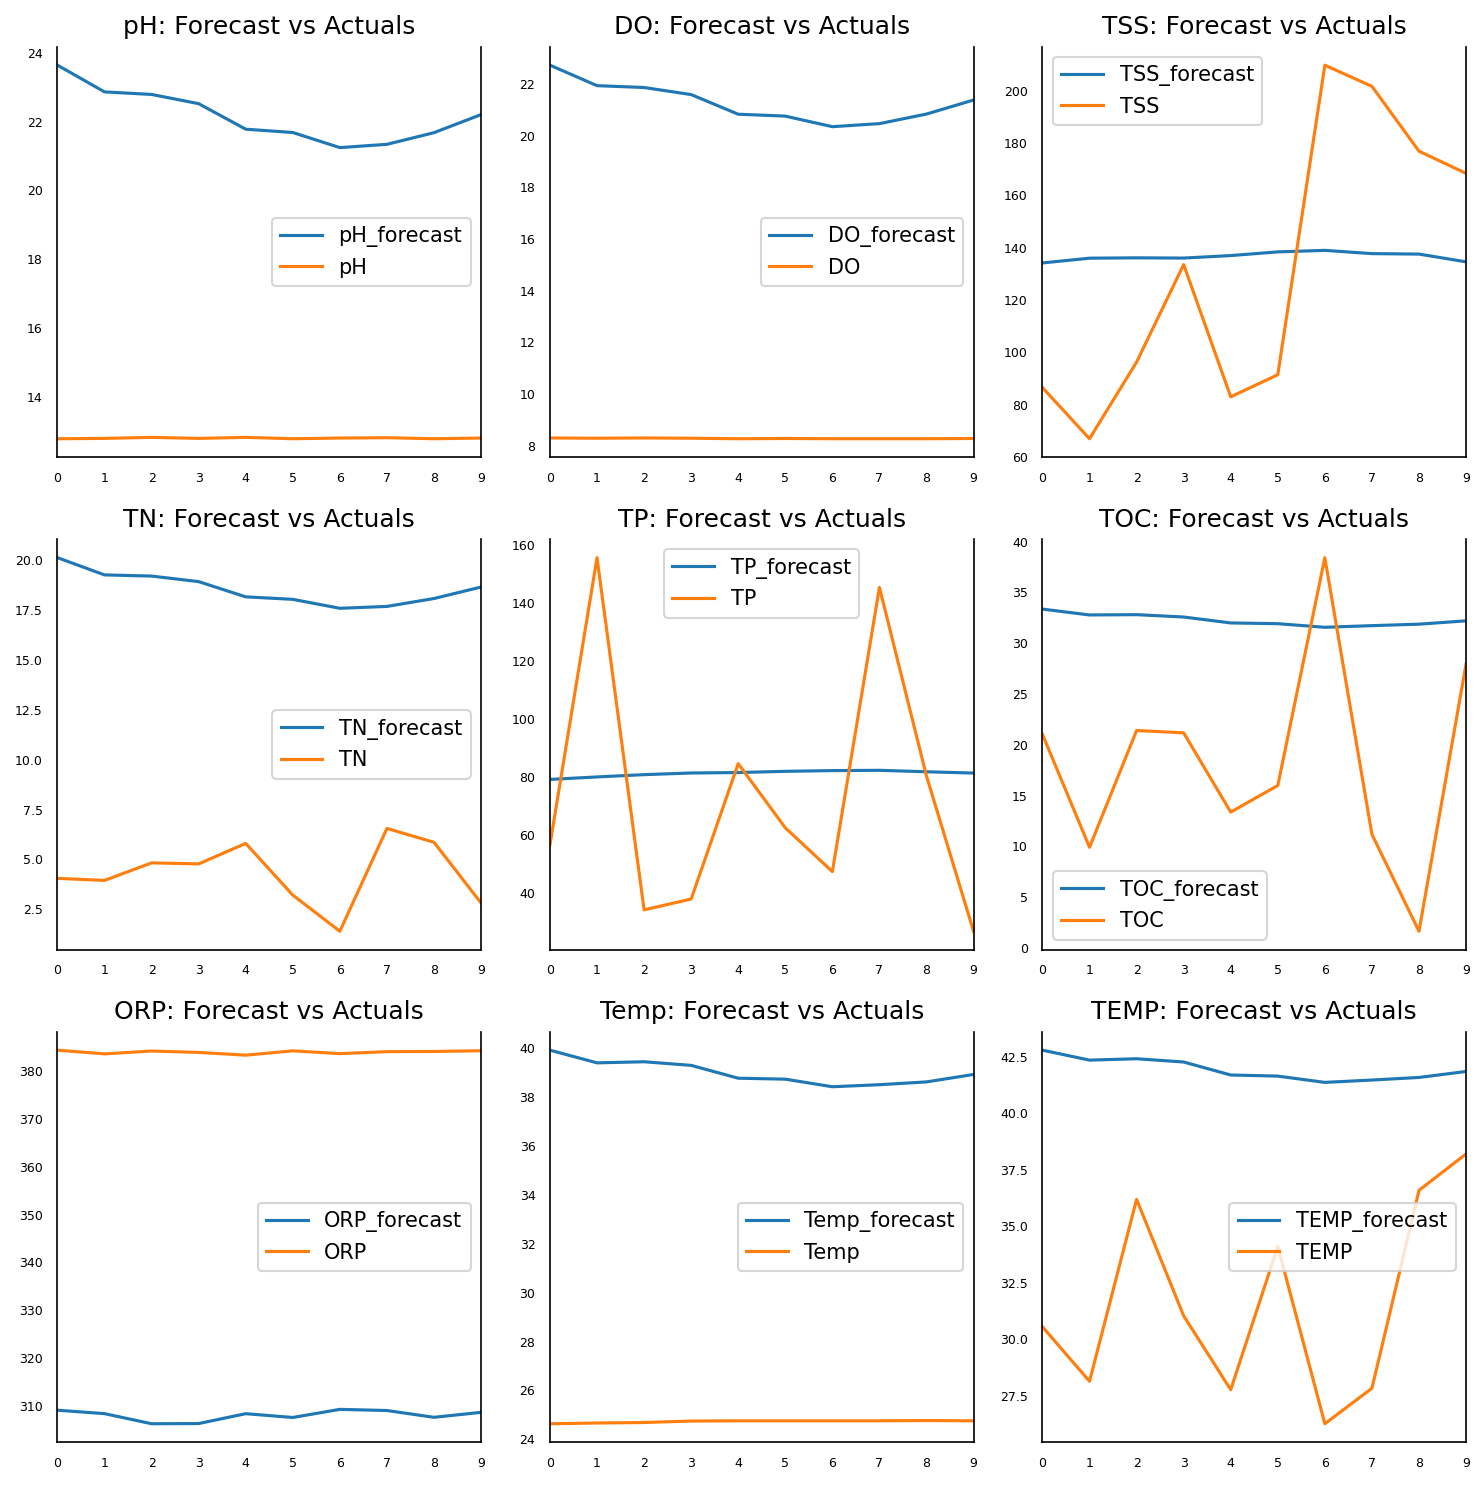

In [36]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results = pd.DataFrame({f'{col}_forecast': y_pred[-1][:,i]})
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test = pd.DataFrame({f'{col}': y_test[-1][:,i]})
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout(); 

#Conv + LSTM 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Xây dựng mô hình convolution dilated với skip connection
def build_cnn_lstm_model(n_timesteps, n_features, n_targetstep, n_filters=32, kernel_size=6, dropout_rate=0.2):
    # Đầu vào mô hình
    inputs = Input(shape=(n_timesteps, n_features))
    
    x = tf.keras.layers.Reshape((n_timesteps * n_features,))(inputs)
    # Dense layer to remove trend
    trend = Dense(1, activation='linear')(x)
    # trend = tf.keras.layers.Reshape((1, 1))(x)
    # Reshape input
    x = inputs
    
    x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding='causal')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = Conv1D(filters=32, kernel_size=kernel_size, activation='relu', padding='causal')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    outputs_cnn = Conv1D(filters=9, kernel_size=11, activation='linear')(x)
    # Đầu ra mô hình
    outputs = tf.keras.layers.LSTM(n_features, activation='relu', input_shape = (n_targetstep, n_features), return_sequences= True)(outputs_cnn)
    

    outputs = Add()([outputs, trend])

    # Đóng gói mô hình
    model = Model(inputs=inputs, outputs=outputs)
    return model
model = build_cnn_lstm_model(n_timesteps = 20, n_features = 9, n_targetstep = 10, n_filters=32, kernel_size=6, dropout_rate=0.2)

# Biên dịch mô hình và huấn luyện với dữ liệu
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 9)]      0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 20, 64)       3520        ['input_4[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 20, 64)       0           ['conv1d_10[0][0]']              
                                                                                                  
 conv1d_11 (Conv1D)             (None, 20, 32)       12320       ['dropout_8[0][0]']              
                                                                                            

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train, y_train, epochs=50, verbose =1, batch_size=256, validation_data=(X_val, y_val),
          callbacks=[callback])

Epoch 1/50
1325/1325 [==============================] - 40s 28ms/step - loss: 7586.8496 - val_loss: 2121.3850
Epoch 2/50
1325/1325 [==============================] - 34s 26ms/step - loss: 4775.6104 - val_loss: 2063.1775
Epoch 3/50
1325/1325 [==============================] - 36s 27ms/step - loss: 4555.0894 - val_loss: 2031.6724
Epoch 4/50
1325/1325 [==============================] - 36s 27ms/step - loss: 4512.0117 - val_loss: 2075.1633
Epoch 5/50
1325/1325 [==============================] - 35s 27ms/step - loss: 4490.2988 - val_loss: 2059.6709


In [ ]:
y_pred = model.predict(X_test)
np.save('LSTNet.npy', y_pred)

3/3 [==============================] - 0s 17ms/step


In [ ]:
for i,j in zip(range(9),['pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp', 'TEMP']):
  print(j,' RMSE ',mean_squared_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i], squared = False))
  print(j,' MAE ',mean_absolute_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i]))

pH  RMSE  19.646758763116082
pH  MAE  19.598330877814497
DO  RMSE  23.96826807664599
DO  MAE  23.92879566654689
TSS  RMSE  106.46499516007397
TSS  MAE  88.96061267929966
TN  RMSE  28.569008862379185
TN  MAE  28.48324220453309
TP  RMSE  70.31863228219795
TP  MAE  46.36844000218997
TOC  RMSE  16.54063000612214
TOC  MAE  14.319185844320605
ORP  RMSE  5.8070687338323985
ORP  MAE  4.72587119690801
Temp  RMSE  12.75189925016676
Temp  MAE  12.618913468051964
TEMP  RMSE  11.342772412142956
TEMP  MAE  10.3642019038725


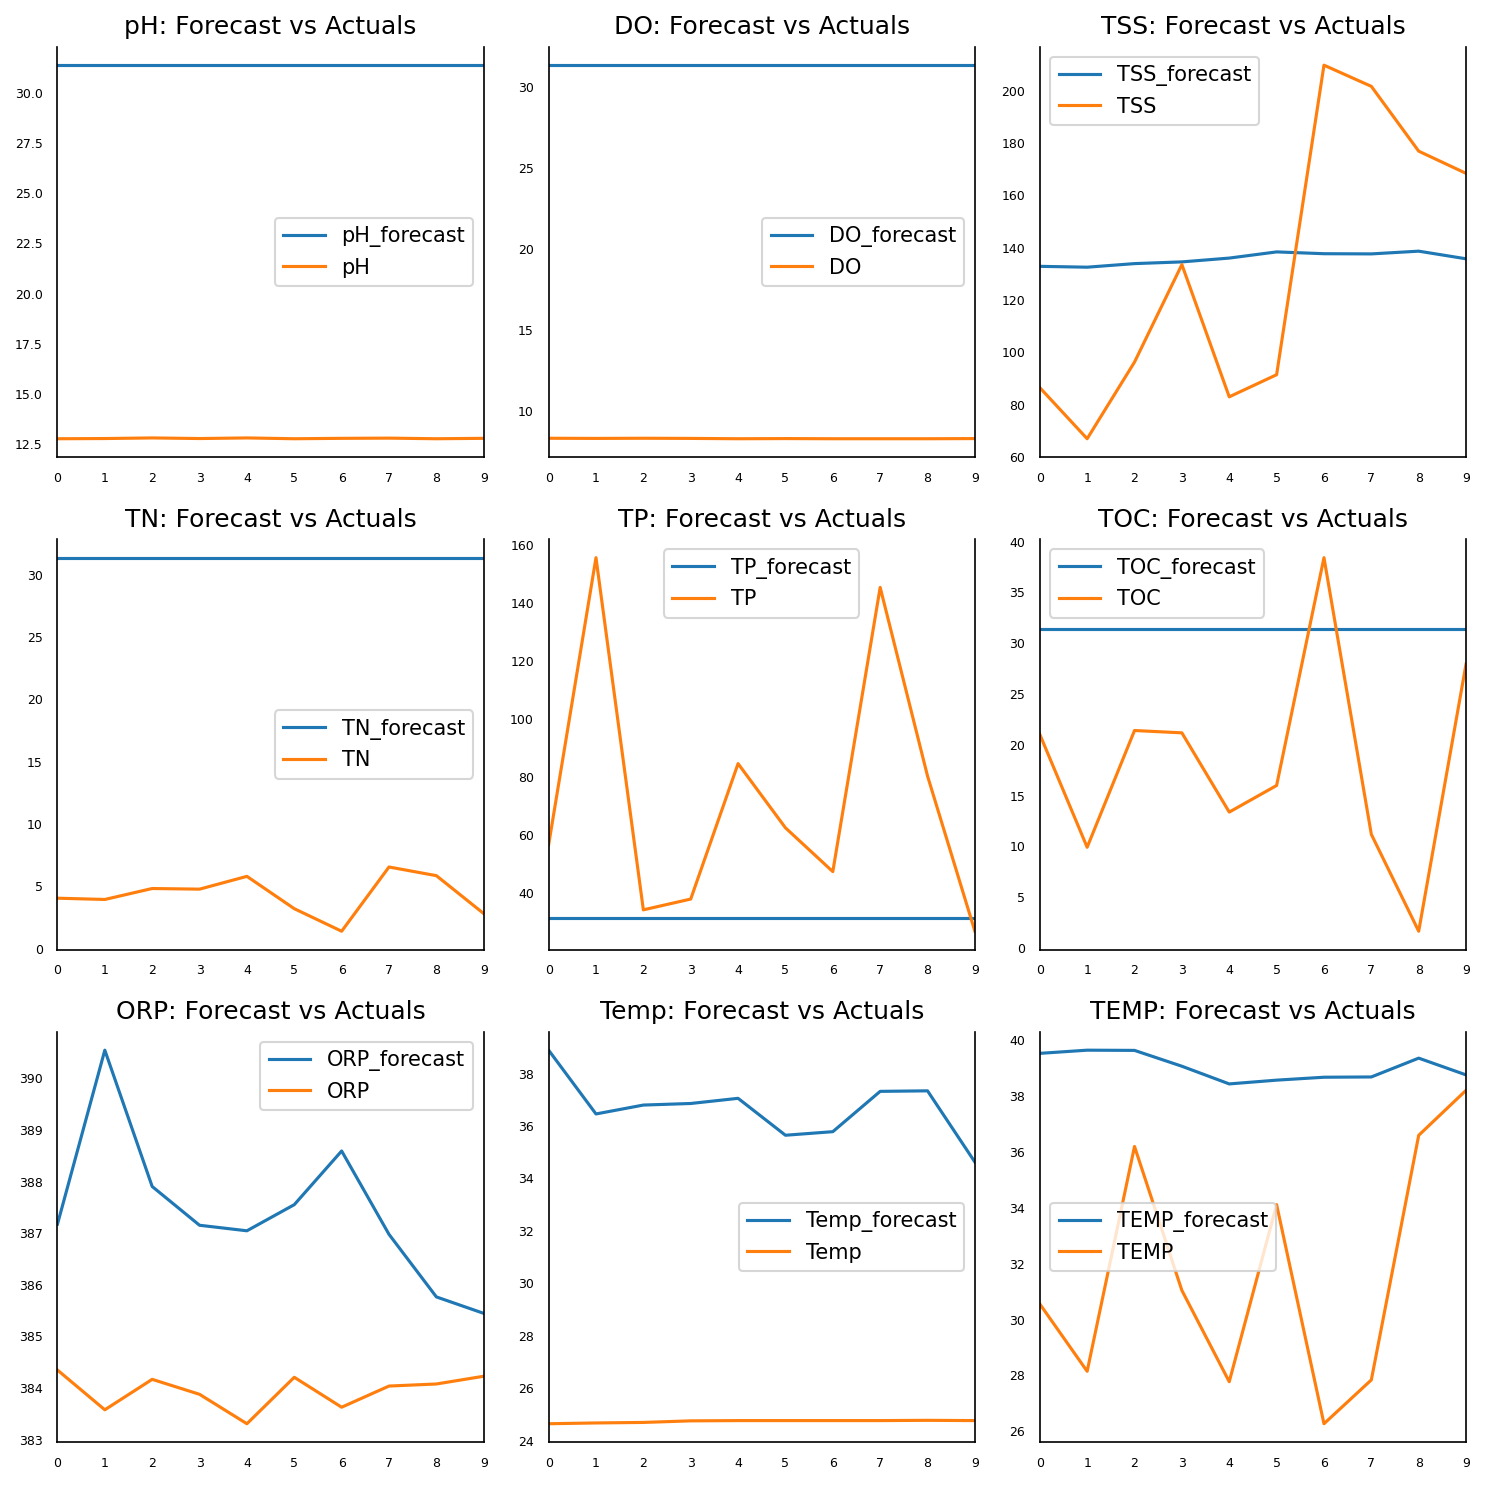

In [ ]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results = pd.DataFrame({f'{col}_forecast': y_pred[-1][:,i]})
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test = pd.DataFrame({f'{col}': y_test[-1][:,i]})
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout(); 